In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [189]:
dataset = 'svhn'
boo_name = 'BoostedNet'
w_name = 'L2W-DEN'
our_name = 'ConfEE'

if dataset == 'cifar10':
    model = 't2t_7'
    long_name = 't2t_vit_7'
    total_mudaa = 13.4
    end_acc = 94.5
    lambda_val_1 = 0.1
    lambda_val_2 = 0.9
    end_plot_acc = 0.85*end_acc
    line_acc = end_acc*0.9
    line_acc_label =r'$90\%$ of end accuracy'
    L=7
elif dataset == 'cifar100':
    model = 't2t_14'
    long_name = 't2t_vit_14'
    total_mudaa = 56
    end_acc = 88.4
    L=14
    lambda_val_1 = 0.01
    lambda_val_2 = 0.9
    end_plot_acc = 0.5*end_acc
    line_acc = end_acc*0.7
    line_acc_label =r'$70\%$ of end accuracy'
elif dataset == 'svhn':
    L=7
    end_acc = 92
    end_plot_acc = 0.2*end_acc
    line_acc = end_acc*0.9
    line_acc_label =r'$90\%$ of end accuracy'
    model = 't2t_7'
    long_name = 't2t_vit_7'
    total_mudaa = 4.3
    
    lambda_val_1 = 0.1
    lambda_val_2 = 4

In [190]:
with open(dataset+'_'+model+'/'+long_name+'_boosted_'+dataset+'_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
with open(dataset+'_'+model+'/'+long_name+'_weighted_'+dataset+'_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)
# with open(dataset+'_'+model+'/'+long_name+'_baseline_'+dataset+'_results.pk', 'rb') as file:
#         list_dict_baseline = pk.load(file)

In [191]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
   
    if '.pk' in file_name and 'baseline' not in file_name and 'boosted' not in file_name and 'weighted' not in file_name:
        lambda_val = float(file_name.split('_')[-2])
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        dicts['lambda'] = lambda_val
        list_dicts_ours.append(dicts)
        print(lambda_val)
        if lambda_val == lambda_val_1:
            our_point_to_display = dicts
            print('got point 1')
        if lambda_val == lambda_val_2:
            our_point2_to_display = dicts
            print('got point 2')

09-20-2023_svhn_0.8_results.pk
0.8
09-20-2023_svhn_3.0_results.pk
3.0
09-20-2023_svhn_0.55_results.pk
0.55
09-19-2023_svhn_0.6_results.pk
0.6
09-20-2023_svhn_1.5_results.pk
1.5
09-19-2023_svhn_0.1_results.pk
0.1
got point 1
09-20-2023_svhn_0.05_results.pk
0.05
09-20-2023_svhn_2.0_results.pk
2.0
09-20-2023_svhn_6.0_results.pk
6.0
09-19-2023_svhn_0.3_results.pk
0.3
09-20-2023_svhn_4.0_results.pk
4.0
got point 2
09-20-2023_svhn_7.0_results.pk
7.0
09-20-2023_svhn_5.0_results.pk
5.0
09-20-2023_svhn_0.9_results.pk
0.9


In [192]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys_dict = {}
    C_keys_dict = {}
    for key in metrics.keys():
        if 'emp_alpha' in key:
            tokens = key.split('emp_alpha')
            alpha = tokens[1]
            prefix = tokens[0]
            
            cov_key = prefix+'emp_alpha'+alpha
            C_key = prefix+'C'+alpha
            if prefix in cov_keys_dict:
                cov_keys_dict[prefix].append(cov_key)
                C_keys_dict[prefix].append(C_key)
            else:
                cov_keys_dict[prefix] = [cov_key] 
                C_keys_dict[prefix] = [C_key]  
    return cov_keys_dict, C_keys_dict

def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
            alpha_val = float(cov_key.split('_')[-1])
            emp_alpha = metrics_we_care_about['average'+cov_key]
            if emp_alpha< requested_alpha:
                if alpha_max < alpha_val:
                    alpha_max = alpha_val
                    #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            

In [193]:
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys_dict, C_keys_dict = get_all_cov_C(list_dicts_ours[0])


type_of_conf = 'test/sets_gated_'
cov_keys = cov_keys_dict[type_of_conf]
C_keys = C_keys_dict[type_of_conf]
cov_keys_baseline = cov_keys
C_keys_baseline = C_keys
# cov_keys_baseline = [c.split('test/')[-1] for c in cov_keys] # dumb storing thing, have to remove the test/ fo rhte baseline
# C_keys_baseline = [c.split('test/')[-1] for c in C_keys] 

print(cov_keys)
print(cov_keys_baseline)
keys_we_want = keys_we_want + cov_keys + C_keys
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')




['test/sets_gated_emp_alpha_0.01', 'test/sets_gated_emp_alpha_0.015', 'test/sets_gated_emp_alpha_0.02', 'test/sets_gated_emp_alpha_0.025', 'test/sets_gated_emp_alpha_0.03', 'test/sets_gated_emp_alpha_0.035', 'test/sets_gated_emp_alpha_0.04', 'test/sets_gated_emp_alpha_0.045', 'test/sets_gated_emp_alpha_0.05']
['test/sets_gated_emp_alpha_0.01', 'test/sets_gated_emp_alpha_0.015', 'test/sets_gated_emp_alpha_0.02', 'test/sets_gated_emp_alpha_0.025', 'test/sets_gated_emp_alpha_0.03', 'test/sets_gated_emp_alpha_0.035', 'test/sets_gated_emp_alpha_0.04', 'test/sets_gated_emp_alpha_0.045', 'test/sets_gated_emp_alpha_0.05']


In [194]:
keys_we_want

['test/acc_exit',
 'test/total_cost',
 'test/gated_acc',
 'test/gated_ece',
 'test/gated_ece',
 'test/sets_gated_emp_alpha_0.01',
 'test/sets_gated_emp_alpha_0.015',
 'test/sets_gated_emp_alpha_0.02',
 'test/sets_gated_emp_alpha_0.025',
 'test/sets_gated_emp_alpha_0.03',
 'test/sets_gated_emp_alpha_0.035',
 'test/sets_gated_emp_alpha_0.04',
 'test/sets_gated_emp_alpha_0.045',
 'test/sets_gated_emp_alpha_0.05',
 'test/sets_gated_C_0.01',
 'test/sets_gated_C_0.015',
 'test/sets_gated_C_0.02',
 'test/sets_gated_C_0.025',
 'test/sets_gated_C_0.03',
 'test/sets_gated_C_0.035',
 'test/sets_gated_C_0.04',
 'test/sets_gated_C_0.045',
 'test/sets_gated_C_0.05']

In [195]:
requested_alpha = 0.05

In [196]:
our_df = pd.DataFrame()
for metrics in list_dicts_ours:
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])/total_mudaa
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    metrics_we_care_about['ACC'] = metrics_we_care_about['test/gated_acc'] 
    
    metrics_we_care_about['ECE'] =metrics_we_care_about['test/gated_ece'] 
    
    for cov_key in cov_keys:
        alpha = float(cov_key.split('alpha_')[-1])
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        
        metrics_we_care_about['alpha'+cov_key] = alpha
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
        
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
    
    
    if alpha_max >0 :
        C_key = type_of_conf+'C_'+str(alpha_max)
        
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)
    
our_point_ic  = np.mean(our_point_to_display['test/total_cost'])
our_point_acc  = np.mean(our_point_to_display['test/gated_acc'])
our_point2_ic = np.mean(our_point2_to_display['test/total_cost'])
our_point2_acc  = np.mean(our_point2_to_display['test/gated_acc'])
our_df['method'] = our_name

In [197]:
def replace_if_closer(points,closest_to_points, val, this_point):
    for i, point in enumerate(points):
        dif_now = np.abs(val-point)
        #print(dif_now)
        dif_prev = closest_to_points[i][1]
        if dif_now< dif_prev:
            closest_to_points[i] = (this_point, dif_now)
    return closest_to_points
def collect_baseline_data(list_dict_baseline, points):
    baseline_df = pd.DataFrame()
    closest_to_points = [(None, 100) for _ in points]
    for metrics in list_dict_baseline:
        metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])/total_mudaa
        metrics['average_ACC'] = np.mean(metrics['ACC'])
        ic = np.mean(metrics['EXPECTED_FLOPS'])
        
        closest_to_points = replace_if_closer(points,closest_to_points, ic, metrics)
        for cov_key in cov_keys_baseline:
            alpha = float(cov_key.split('alpha_')[-1])
            metrics['average'+cov_key] = np.mean(metrics[cov_key])
            metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
        for C_key in C_keys_baseline:
            metrics['average'+C_key] = np.mean(metrics[C_key])
            print(np.mean(metrics_we_care_about[C_key]))
        alpha_max = find_highest_cov(metrics, cov_keys_baseline, requested_alpha)
        
        if alpha_max >0 :
            C_key = type_of_conf+'C_'+str(alpha_max)
            metrics['C'] = metrics[C_key]
            metrics['emp_alpha'] = alpha_max
        df = pd.DataFrame(data=metrics)
        baseline_df = pd.concat([df, baseline_df],axis=0, ignore_index=True)
    return baseline_df, [tuple_points[0] for tuple_points in closest_to_points]


boosted_df, boosted_points = collect_baseline_data(list_dict_boosted, [our_point_ic, our_point2_ic])
boosted_df['method'] = boo_name
weighted_df, weighted_points = collect_baseline_data(list_dict_weighted, [our_point_ic, our_point2_ic])
weighted_df['method'] = w_name

# baseline_df, baseline_points = collect_baseline_data(list_dict_baseline, [our_point_ic, our_point2_ic])
# baseline_df['method'] = 'baseline'
# baseline_df['average_IC'] = baseline_df['average_IC']/1000000

5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.031

/tmp/ipykernel_97359/2081627108.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  boosted_df['method'] = boo_name


5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.0314435688862007
5.0169868851576656
4.021168637119791
3.3741533247491446
3.0619652649529927
2.834126617373414
2.5547711614621726
2.3815389518381807
2.1958735839549943
2.031

/tmp/ipykernel_97359/2081627108.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_df['method'] = w_name


In [198]:
boosted_point_ic  = np.mean(boosted_points[0]['EXPECTED_FLOPS'])
boosted_point_acc  = np.mean(boosted_points[0]['ACC'])
boosted_point2_ic  = np.mean(boosted_points[1]['EXPECTED_FLOPS'])
boosted_point2_acc  = np.mean(boosted_points[1]['ACC'])

weighted_point_ic  = np.mean(weighted_points[0]['EXPECTED_FLOPS'])
weighted_point_acc  = np.mean(weighted_points[0]['ACC'])
weighted_point2_ic  = np.mean(weighted_points[1]['EXPECTED_FLOPS'])
weighted_point2_acc  = np.mean(weighted_points[1]['ACC'])

In [199]:
filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(end_plot_acc, end_acc)]
filtered_our_df = our_df[our_df['average_ACC'].between(end_plot_acc, end_acc)]
filtered_weighted_df = weighted_df[weighted_df['average_ACC'].between(end_plot_acc, end_acc)]
#filtered_baseline_df   = baseline_df[baseline_df['average_ACC'].between(end_plot_acc, end_acc)]


In [200]:
combined_df = pd.concat([filtered_boosted_df, filtered_weighted_df, filtered_our_df],axis=0, ignore_index=True)

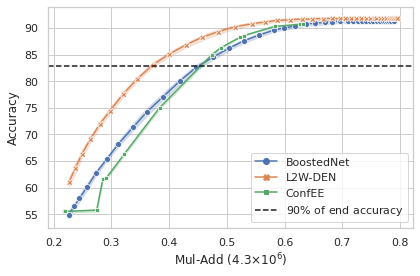

In [201]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
#print(filtered_our_df)

sns.lineplot(data=combined_df, x="average_IC", y="ACC", hue="method", style="method",
    markers=True, dashes=False)
plt.axhline(y=line_acc, color='k',linestyle='--', label=line_acc_label)
plt.legend()
x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
plt.xlabel(x_string)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

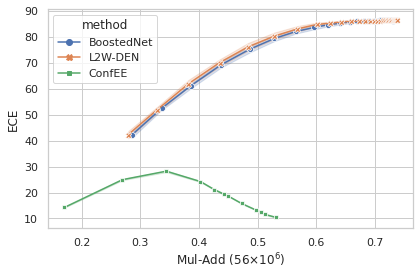

In [138]:
sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
sns.lineplot(data=combined_df, x="average_IC", y="ECE", hue="method", style="method",
    markers=True, dashes=False)
# sns.set_theme(style="whitegrid")
# sns.lineplot(data=filtered_weighted_df, x="average_ACC", y="ECE", label=boo_name)
# sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label=w_name)

# sns.lineplot(data=filtered_our_df, x="average_ACC", y="ECE", label=our_name)
x_string = r'Mul-Add ('+str(total_mudaa)+'$ \\times 10^6$)'
plt.xlabel(x_string)
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

<AxesSubplot:xlabel='average_IC', ylabel='C'>

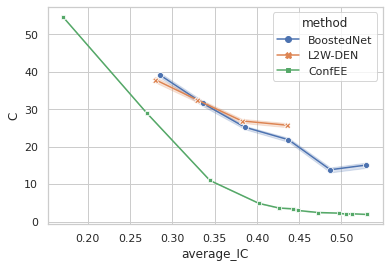

In [139]:
# sns.set(font_scale=1.5)  # crazy big
# sns.set_theme(style="whitegrid")

sns.set(font_scale=1.5) 
sns.set_theme(style="whitegrid")
sns.lineplot(data=combined_df, x="average_IC", y="C", hue="method", style="method",
    markers=True, dashes=False)

# sns.scatterplot(data=filtered_boosted_df, x="average_IC", y="C", label=boo_name)
# sns.scatterplot(data=filtered_weighted_df, x="average_IC", y="C", label=w_name)
# sns.scatterplot(data=filtered_our_df, x="average_IC", y="C", label=our_name)


# plt.xlabel(r'Mul-Add ($\times 10^6$)')
# plt.ylabel(r'$|\mathcal{\bar{C}}|$')
# plt.tight_layout()
# plt.savefig('inef_IC_'+dataset+'.pdf')


In [140]:
weighted_df_emp_vs_req = pd.DataFrame()
boosted_df_emp_vs_req = pd.DataFrame()
our_df_emp_vs_req = pd.DataFrame()
for cov_key in cov_keys_baseline:
    print(cov_key)
    alpha = float(cov_key.split('alpha_')[-1])
    boosted_df_cov = pd.DataFrame()
    boosted_df_cov['emp_alpha'] = boosted_df[cov_key]
    boosted_df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([boosted_df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = weighted_df[cov_key]
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)

    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

test/sets_gated_emp_alpha_0.01
test/sets_gated_emp_alpha_0.015
test/sets_gated_emp_alpha_0.02
test/sets_gated_emp_alpha_0.025
test/sets_gated_emp_alpha_0.03
test/sets_gated_emp_alpha_0.035
test/sets_gated_emp_alpha_0.04
test/sets_gated_emp_alpha_0.045
test/sets_gated_emp_alpha_0.05


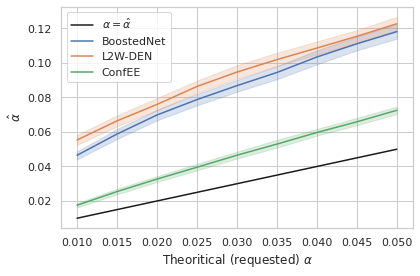

In [141]:
x = [0.01,0.05]
y = [0.01,0.05]
sns.set_theme(style="whitegrid")
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=boo_name)
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=w_name)
sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label=our_name)

plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('emp_vs_theoritical_'+dataset+'.pdf')

In [142]:
def plotting_point(point,metrics, w_metrics, prefix):
    df_acc_ours = pd.DataFrame()
    for l in range(L):

        all_acc = 'test/acc'+str(l)

        gated_acc = 'test/gated_acc_'+str(l)
        percent_exit = 'test/percent_exit'+str(l)
        if gated_acc in point and len(point[gated_acc]) == 10:

            df_acc = pd.DataFrame()

            df_acc['gated'] = point[gated_acc]
            df_acc['all'] = point[all_acc]
            df_acc['gate'] = l
            percent_exit = point[percent_exit]

            df_acc['fraction exit'] = np.mean([100*p for p in percent_exit])
            df_acc_ours = pd.concat([df_acc_ours, df_acc],axis=0, ignore_index=True)
        print('l', l, np.mean(point[all_acc]))
    df_acc_ours['method'] = 'ConFEE'

    df_acc_boosted = pd.DataFrame()

    for l in range(L):
        all_acc = 'ALL_ACC_PER_GATE_'+str(l)
        gated_acc = 'GATED_ACC_PER_GATE_'+str(l)
        num_exit = 'EXIT_RATE_PER_GATE_'+str(l)
        if gated_acc in metrics:
            df_acc = pd.DataFrame()
            df_acc['gated'] = metrics[gated_acc]
            df_acc['all'] = metrics[all_acc]
            df_acc['gate'] = l
            df_acc['fraction exit'] = np.mean(metrics[num_exit])
            df_acc_boosted = pd.concat([df_acc_boosted, df_acc],axis=0, ignore_index=True)
    df_acc_boosted['method'] = boo_name      

    df_acc_weighted = pd.DataFrame()

    for l in range(L):
        all_acc = 'ALL_ACC_PER_GATE_'+str(l)
        gated_acc = 'GATED_ACC_PER_GATE_'+str(l)
        num_exit = 'EXIT_RATE_PER_GATE_'+str(l)
        if gated_acc in w_metrics:
            df_acc = pd.DataFrame()
            df_acc['gated'] = w_metrics[gated_acc]
            df_acc['all'] = w_metrics[all_acc]
            df_acc['gate'] = l
            df_acc['fraction exit'] = np.mean(w_metrics[num_exit])
            df_acc_weighted = pd.concat([df_acc_weighted, df_acc],axis=0, ignore_index=True)

    df_acc_weighted['method'] = w_name

    df_acc =  pd.concat([df_acc_boosted, df_acc_ours, df_acc_weighted],axis=0, ignore_index=True)
    
    sns.set(font_scale=1.3) 
    sns.set_theme(style="whitegrid")

    g = sns.relplot(
        data=df_acc,
        x="gate", y="gated", hue='method', label="gated acc", size="fraction exit",
         sizes=(10, 200))
    g.despine(left=True, bottom=True)
    g.set(xlabel ="Gate", ylabel = "Accuracy on exited points")
    g._legend.remove()
    plt.tight_layout()
    
    plt.savefig(prefix+'_'+dataset+'gated_acc.pdf')
    sns.set(font_scale=1.3) 
    sns.set_theme(style="whitegrid")
    g = sns.relplot(
        data=df_acc,
        x="gate", y="all", hue='method', label="gated acc", size="fraction exit",
         sizes=(10, 200))
    g.despine(left=True, bottom=True)
    g.set(xlabel ="Gate", ylabel = "Accuracy on all points")
    plt.tight_layout()
    plt.savefig(prefix+'_'+dataset+'all_acc.pdf')

In [143]:
point = our_point_to_display
metrics = boosted_points[0]
w_metrics = weighted_points[0]
plotting_point(point,metrics, w_metrics,prefix='better' )
point = our_point2_to_display
metrics = boosted_points[1]
w_metrics = weighted_points[1]
plotting_point(point,metrics, w_metrics,prefix='worst' )

l 0 40.50355158730159
l 1 56.29230952380952
l 2 70.19392857142857
l 3 84.57514285714286
l 4 92.32628968253968
l 5 94.81970634920634
l 6 94.93788492063493


KeyError: 'test/acc7'

In [193]:

print([np.mean(point['test/acc'+str(l)]) for l in range(L)])



[7.590111111111112, 12.799888888888889, 17.43956746031746, 31.271182539682542, 39.20516666666667, 53.71674206349206, 63.90031746031745, 75.03771031746032, 78.51403571428571, 83.89396428571429, 86.40959523809525, 87.79219444444445, 87.58321031746033, 88.1498373015873]
